# Architecture Sweep: MLP Bottlenecks in L=10 vs L=40

**Goal**: Understand if MLP architecture creates bottlenecks that affect L=10 vs L=40 differently.

## Hypothesis
- L=40 has 1600 SH features → 256-dim embedding (16x compression)
- L=10 has 100 SH features → 256-dim embedding (2.5x expansion)
- Maybe L=40's richer embeddings need more MLP capacity to exploit?
- Or maybe L=10's simpler features are easier to learn from?

## Sweep Variables
1. **Coverage**: Global, USA, Europe, China, Brazil, Africa + coverage sizes
2. **Models**: L=10 vs L=40
3. **Architectures**:
   - Linear (Ridge) - baseline
   - Tiny MLP (32)
   - Small MLP (64)
   - Medium MLP (128, 64) - default
   - Wide MLP (512, 256)
   - Deep MLP (256, 128, 64, 32)
   - Very Deep (256, 256, 128, 128, 64, 64)

## Key Questions
- Does L=40 benefit more from deeper/wider networks?
- Is there an architecture where L=10 matches L=40 regionally?
- Does the optimal architecture differ by geographic scale?

In [1]:
# Setup
import os
import sys

if 'COLAB_GPU' in os.environ:
    !rm -rf sample_data .config satclip gpw_data 2>/dev/null
    !git clone https://github.com/1hamzaiqbal/satclip.git
    !pip install lightning torchgeo huggingface_hub geopandas shapely requests rasterio --quiet

Cloning into 'satclip'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 457 (delta 202), reused 165 (delta 132), pack-reused 187 (from 2)
Receiving objects: 100% (457/457), 80.31 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (230/230), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.7 MB/s eta 0:00:00
   ━━━━

In [2]:
# Mount Google Drive and extract GPW data
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

GPW_DIR = './gpw_data'
os.makedirs(GPW_DIR, exist_ok=True)

SOURCE_ZIP_PATH = '/content/drive/MyDrive/grad/learned_activations/dataverse_files.zip'

print("Extracting GPW data...")
with zipfile.ZipFile(SOURCE_ZIP_PATH, 'r') as z:
    z.extractall(GPW_DIR)

# Extract resolution TIFs
RESOLUTIONS_TO_EXTRACT = ['15_min', '2pt5_min']  # Use 2 resolutions for speed
YEAR = 2020

for res in RESOLUTIONS_TO_EXTRACT:
    zip_name = f"gpw-v4-population-density-rev11_{YEAR}_{res}_tif.zip"
    zip_path = os.path.join(GPW_DIR, zip_name)
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(GPW_DIR)
        print(f"  Extracted {zip_name}")

print("Done!")

Mounted at /content/drive
Extracting GPW data...
  Extracted gpw-v4-population-density-rev11_2020_15_min_tif.zip
  Extracted gpw-v4-population-density-rev11_2020_2pt5_min_tif.zip
Done!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

if 'COLAB_GPU' in os.environ:
    sys.path.append('./satclip/satclip')
    GPW_DIR = './gpw_data'
else:
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'satclip'))
    GPW_DIR = './gpw_data'

import torch
from huggingface_hub import hf_hub_download
from load import get_satclip
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load models
print("Loading SatCLIP models...")
model_l10 = get_satclip(hf_hub_download("microsoft/SatCLIP-ViT16-L10", "satclip-vit16-l10.ckpt"), device=device)
model_l40 = get_satclip(hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"), device=device)
model_l10.eval()
model_l40.eval()
print("Models loaded!")

def get_embeddings(model, coords, batch_size=1000):
    """Get embeddings with batching."""
    all_emb = []
    for i in range(0, len(coords), batch_size):
        batch = coords[i:i+batch_size]
        coords_tensor = torch.tensor(batch).double()
        with torch.no_grad():
            emb = model(coords_tensor.to(device)).cpu().numpy()
        all_emb.append(emb)
    return np.vstack(all_emb)

Using device: cuda
Loading SatCLIP models...


satclip-vit16-l10.ckpt:   0%|          | 0.00/103M [00:00<?, ?B/s]

using pretrained moco vit16
Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_moco/resolve/1cb683f6c14739634cdfaaceb076529adf898c74/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_moco-67c9032d.pth


100%|██████████| 86.5M/86.5M [00:00<00:00, 387MB/s]


satclip-vit16-l40.ckpt:   0%|          | 0.00/121M [00:00<?, ?B/s]

using pretrained moco vit16
Models loaded!


In [4]:
# Data loading functions
Image.MAX_IMAGE_PIXELS = None

try:
    import rasterio
    HAS_RASTERIO = True
except ImportError:
    HAS_RASTERIO = False

RESOLUTIONS = {
    '15_min': {'name': '15 arc-min', 'km': 28},
    '2pt5_min': {'name': '2.5 arc-min', 'km': 5},
}

def load_gpw_raster(resolution, year=2020):
    """Load GPW population density raster."""
    tif_file = f"{GPW_DIR}/gpw_v4_population_density_rev11_{year}_{resolution}.tif"
    if not os.path.exists(tif_file):
        print(f"File not found: {tif_file}")
        return None, None

    if HAS_RASTERIO:
        with rasterio.open(tif_file) as src:
            data = src.read(1)
            height, width = data.shape
    else:
        img = Image.open(tif_file)
        data = np.array(img)
        height, width = data.shape

    lon_step = 360 / width
    lat_step = 180 / height
    lons = np.linspace(-180 + lon_step/2, 180 - lon_step/2, width)
    lats = np.linspace(90 - lat_step/2, -90 + lat_step/2, height)

    return data, (lons, lats)

def sample_from_raster(data, coords, n_samples=10000, seed=42, bounds=None):
    """Sample random valid points from population raster."""
    np.random.seed(seed)
    lons, lats = coords
    valid_mask = data > -1e30

    if bounds is not None:
        lon_min, lat_min, lon_max, lat_max = bounds
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        bounds_mask = (
            (lon_grid >= lon_min) & (lon_grid <= lon_max) &
            (lat_grid >= lat_min) & (lat_grid <= lat_max)
        )
        valid_mask = valid_mask & bounds_mask

    valid_idx = np.where(valid_mask)
    n_valid = len(valid_idx[0])

    if n_valid < n_samples:
        sample_idx = np.arange(n_valid)
    else:
        sample_idx = np.random.choice(n_valid, n_samples, replace=False)

    row_idx = valid_idx[0][sample_idx]
    col_idx = valid_idx[1][sample_idx]

    sample_lons = lons[col_idx]
    sample_lats = lats[row_idx]
    sample_values = data[row_idx, col_idx]

    coords_arr = np.stack([sample_lons, sample_lats], axis=1)
    return coords_arr, sample_values

# Load data
print("Loading population data...")
data_15min, coords_15min = load_gpw_raster('15_min')
print(f"  15-min: {data_15min.shape if data_15min is not None else 'Not found'}")

Loading population data...
  15-min: (720, 1440)


---
## Define Architectures to Test

In [5]:
# Define all architectures to test
ARCHITECTURES = {
    # Linear baselines
    'Linear (Ridge)': {'type': 'ridge', 'alpha': 1.0},
    'Linear (Ridge strong)': {'type': 'ridge', 'alpha': 100.0},

    # MLP variants - varying depth and width
    'MLP Tiny (32)': {'type': 'mlp', 'hidden': (32,)},
    'MLP Small (64)': {'type': 'mlp', 'hidden': (64,)},
    'MLP Medium (128,64)': {'type': 'mlp', 'hidden': (128, 64)},  # Default
    'MLP Wide (256,128)': {'type': 'mlp', 'hidden': (256, 128)},
    'MLP Wider (512,256)': {'type': 'mlp', 'hidden': (512, 256)},
    'MLP Deep (128,128,64,64)': {'type': 'mlp', 'hidden': (128, 128, 64, 64)},
    'MLP Very Deep (256,256,128,128,64,64)': {'type': 'mlp', 'hidden': (256, 256, 128, 128, 64, 64)},
    'MLP Bottleneck (256,32,256)': {'type': 'mlp', 'hidden': (256, 32, 256)},  # Compression test

    # Alternative regressors
    'KNN (k=10)': {'type': 'knn', 'n_neighbors': 10},
    'KNN (k=50)': {'type': 'knn', 'n_neighbors': 50},
    'Random Forest': {'type': 'rf', 'n_estimators': 100, 'max_depth': 10},
    'Gradient Boosting': {'type': 'gb', 'n_estimators': 100, 'max_depth': 5},
}

# Coverages to test
COVERAGES = {
    'Global': None,
    'USA': (-125, 24, -66, 50),
    'Europe': (-10, 35, 40, 70),
    'China': (73, 18, 135, 54),
    'Brazil': (-74, -34, -34, 6),
    'Africa': (-18, -35, 52, 37),
}

print(f"Architectures to test: {len(ARCHITECTURES)}")
print(f"Coverages to test: {len(COVERAGES)}")
print(f"Models: L=10, L=40")
print(f"Total combinations: {len(ARCHITECTURES) * len(COVERAGES) * 2}")

Architectures to test: 14
Coverages to test: 6
Models: L=10, L=40
Total combinations: 168


In [6]:
def create_regressor(arch_config, seed=42):
    """Create a regressor based on architecture config."""
    arch_type = arch_config['type']

    if arch_type == 'ridge':
        return Ridge(alpha=arch_config.get('alpha', 1.0))

    elif arch_type == 'mlp':
        return MLPRegressor(
            hidden_layer_sizes=arch_config['hidden'],
            max_iter=500,
            random_state=seed,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10
        )

    elif arch_type == 'knn':
        return KNeighborsRegressor(n_neighbors=arch_config.get('n_neighbors', 10))

    elif arch_type == 'rf':
        return RandomForestRegressor(
            n_estimators=arch_config.get('n_estimators', 100),
            max_depth=arch_config.get('max_depth', 10),
            random_state=seed,
            n_jobs=-1
        )

    elif arch_type == 'gb':
        return GradientBoostingRegressor(
            n_estimators=arch_config.get('n_estimators', 100),
            max_depth=arch_config.get('max_depth', 5),
            random_state=seed
        )

    else:
        raise ValueError(f"Unknown architecture type: {arch_type}")


def run_architecture_test(coords, values, model_l10, model_l40, arch_config, test_size=0.5, seed=42):
    """Run regression test with specified architecture for both L=10 and L=40."""
    # Log-transform population
    y = np.log1p(values)

    # Get embeddings
    emb_l10 = get_embeddings(model_l10, coords)
    emb_l40 = get_embeddings(model_l40, coords)

    # Train/test split
    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, y, test_size=test_size, random_state=seed
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, y, test_size=test_size, random_state=seed
    )

    # Scale features
    scaler_l10, scaler_l40 = StandardScaler(), StandardScaler()
    X_train_l10 = scaler_l10.fit_transform(X_train_l10)
    X_test_l10 = scaler_l10.transform(X_test_l10)
    X_train_l40 = scaler_l40.fit_transform(X_train_l40)
    X_test_l40 = scaler_l40.transform(X_test_l40)

    # Create and train regressors
    reg_l10 = create_regressor(arch_config, seed)
    reg_l40 = create_regressor(arch_config, seed)

    start = time.time()
    reg_l10.fit(X_train_l10, y_train)
    reg_l40.fit(X_train_l40, y_train)
    train_time = time.time() - start

    # Evaluate
    r2_l10 = r2_score(y_test, reg_l10.predict(X_test_l10))
    r2_l40 = r2_score(y_test, reg_l40.predict(X_test_l40))

    return {
        'r2_l10': r2_l10,
        'r2_l40': r2_l40,
        'diff': r2_l40 - r2_l10,
        'train_time': train_time
    }

---
## Run Full Sweep

In [7]:
print("="*90)
print("ARCHITECTURE SWEEP: Coverage x Model x Architecture")
print("="*90)

N_SAMPLES = 8000
all_results = []

for coverage_name, bounds in COVERAGES.items():
    print(f"\n{'─'*90}")
    print(f"Coverage: {coverage_name}")
    print(f"{'─'*90}")

    # Sample data for this coverage
    sample_coords, sample_vals = sample_from_raster(
        data_15min, coords_15min, n_samples=N_SAMPLES, bounds=bounds, seed=42
    )

    if len(sample_coords) < 500:
        print(f"  Skipping - only {len(sample_coords)} samples")
        continue

    print(f"  Samples: {len(sample_coords)}")
    print(f"\n  {'Architecture':<35} | {'L=10':>7} | {'L=40':>7} | {'Δ':>8} | {'Time':>6}")
    print(f"  {'-'*75}")

    # Get embeddings once (reuse across architectures)
    emb_l10 = get_embeddings(model_l10, sample_coords)
    emb_l40 = get_embeddings(model_l40, sample_coords)
    y = np.log1p(sample_vals)

    # Split once
    X_train_l10, X_test_l10, y_train, y_test = train_test_split(
        emb_l10, y, test_size=0.5, random_state=42
    )
    X_train_l40, X_test_l40, _, _ = train_test_split(
        emb_l40, y, test_size=0.5, random_state=42
    )

    # Scale
    scaler_l10, scaler_l40 = StandardScaler(), StandardScaler()
    X_train_l10_scaled = scaler_l10.fit_transform(X_train_l10)
    X_test_l10_scaled = scaler_l10.transform(X_test_l10)
    X_train_l40_scaled = scaler_l40.fit_transform(X_train_l40)
    X_test_l40_scaled = scaler_l40.transform(X_test_l40)

    for arch_name, arch_config in ARCHITECTURES.items():
        try:
            # Create regressors
            reg_l10 = create_regressor(arch_config, seed=42)
            reg_l40 = create_regressor(arch_config, seed=42)

            # Train
            start = time.time()
            reg_l10.fit(X_train_l10_scaled, y_train)
            reg_l40.fit(X_train_l40_scaled, y_train)
            train_time = time.time() - start

            # Evaluate
            r2_l10 = r2_score(y_test, reg_l10.predict(X_test_l10_scaled))
            r2_l40 = r2_score(y_test, reg_l40.predict(X_test_l40_scaled))
            diff = r2_l40 - r2_l10

            winner = "L=40" if diff > 0.02 else ("L=10" if diff < -0.02 else "~")
            print(f"  {arch_name:<35} | {r2_l10:>7.3f} | {r2_l40:>7.3f} | {diff:>+7.3f} | {train_time:>5.1f}s")

            all_results.append({
                'coverage': coverage_name,
                'architecture': arch_name,
                'arch_type': arch_config['type'],
                'r2_l10': r2_l10,
                'r2_l40': r2_l40,
                'diff': diff,
                'train_time': train_time,
                'n_samples': len(sample_coords)
            })

        except Exception as e:
            print(f"  {arch_name:<35} | ERROR: {str(e)[:30]}")

results_df = pd.DataFrame(all_results)
print(f"\n\nTotal experiments: {len(results_df)}")

ARCHITECTURE SWEEP: Coverage x Model x Architecture

──────────────────────────────────────────────────────────────────────────────────────────
Coverage: Global
──────────────────────────────────────────────────────────────────────────────────────────
  Samples: 8000

  Architecture                        |    L=10 |    L=40 |        Δ |   Time
  ---------------------------------------------------------------------------
  Linear (Ridge)                      |   0.759 |   0.683 |  -0.076 |   0.2s
  Linear (Ridge strong)               |   0.746 |   0.679 |  -0.067 |   0.1s
  MLP Tiny (32)                       |   0.773 |   0.760 |  -0.013 |   4.1s
  MLP Small (64)                      |   0.783 |   0.761 |  -0.021 |   2.6s
  MLP Medium (128,64)                 |   0.786 |   0.784 |  -0.002 |   3.2s
  MLP Wide (256,128)                  |   0.779 |   0.785 |  +0.006 |   8.7s
  MLP Wider (512,256)                 |   0.772 |   0.782 |  +0.009 |   5.8s
  MLP Deep (128,128,64,64)          

---
## Analysis: Does Architecture Affect L=40 Advantage?

In [8]:
# Pivot table: Coverage x Architecture showing L=40 advantage
print("="*80)
print("L=40 ADVANTAGE (R² diff) BY COVERAGE x ARCHITECTURE")
print("="*80)

if len(results_df) > 0:
    pivot = results_df.pivot(index='architecture', columns='coverage', values='diff')

    # Reorder columns
    col_order = ['Global', 'USA', 'Europe', 'China', 'Brazil', 'Africa']
    pivot = pivot[[c for c in col_order if c in pivot.columns]]

    print("\n" + pivot.round(3).to_string())

    # Summary stats
    print("\n" + "-"*60)
    print("SUMMARY BY ARCHITECTURE (avg L=40 advantage across coverages):")
    arch_avg = results_df.groupby('architecture')['diff'].mean().sort_values(ascending=False)
    for arch, avg in arch_avg.items():
        print(f"  {arch:<40}: {avg:+.3f}")

    print("\n" + "-"*60)
    print("SUMMARY BY COVERAGE (avg L=40 advantage across architectures):")
    cov_avg = results_df.groupby('coverage')['diff'].mean().sort_values(ascending=False)
    for cov, avg in cov_avg.items():
        print(f"  {cov:<20}: {avg:+.3f}")

L=40 ADVANTAGE (R² diff) BY COVERAGE x ARCHITECTURE

coverage                               Global    USA  Europe  China  Brazil  Africa
architecture                                                                       
Gradient Boosting                      -0.013  0.014   0.004  0.009   0.014   0.016
KNN (k=10)                              0.010  0.010   0.009  0.003  -0.001   0.001
KNN (k=50)                              0.021  0.001   0.014  0.022   0.009   0.032
Linear (Ridge strong)                  -0.067  0.040   0.045  0.032   0.045   0.013
Linear (Ridge)                         -0.076  0.069   0.060  0.025   0.047   0.004
MLP Bottleneck (256,32,256)            -0.004  0.064   0.046  0.025   0.064   0.028
MLP Deep (128,128,64,64)                0.001  0.043   0.084  0.013   0.051   0.014
MLP Medium (128,64)                    -0.002  0.101   0.063  0.035   0.065   0.048
MLP Small (64)                         -0.021  0.070   0.096  0.036   0.079   0.042
MLP Tiny (32)          

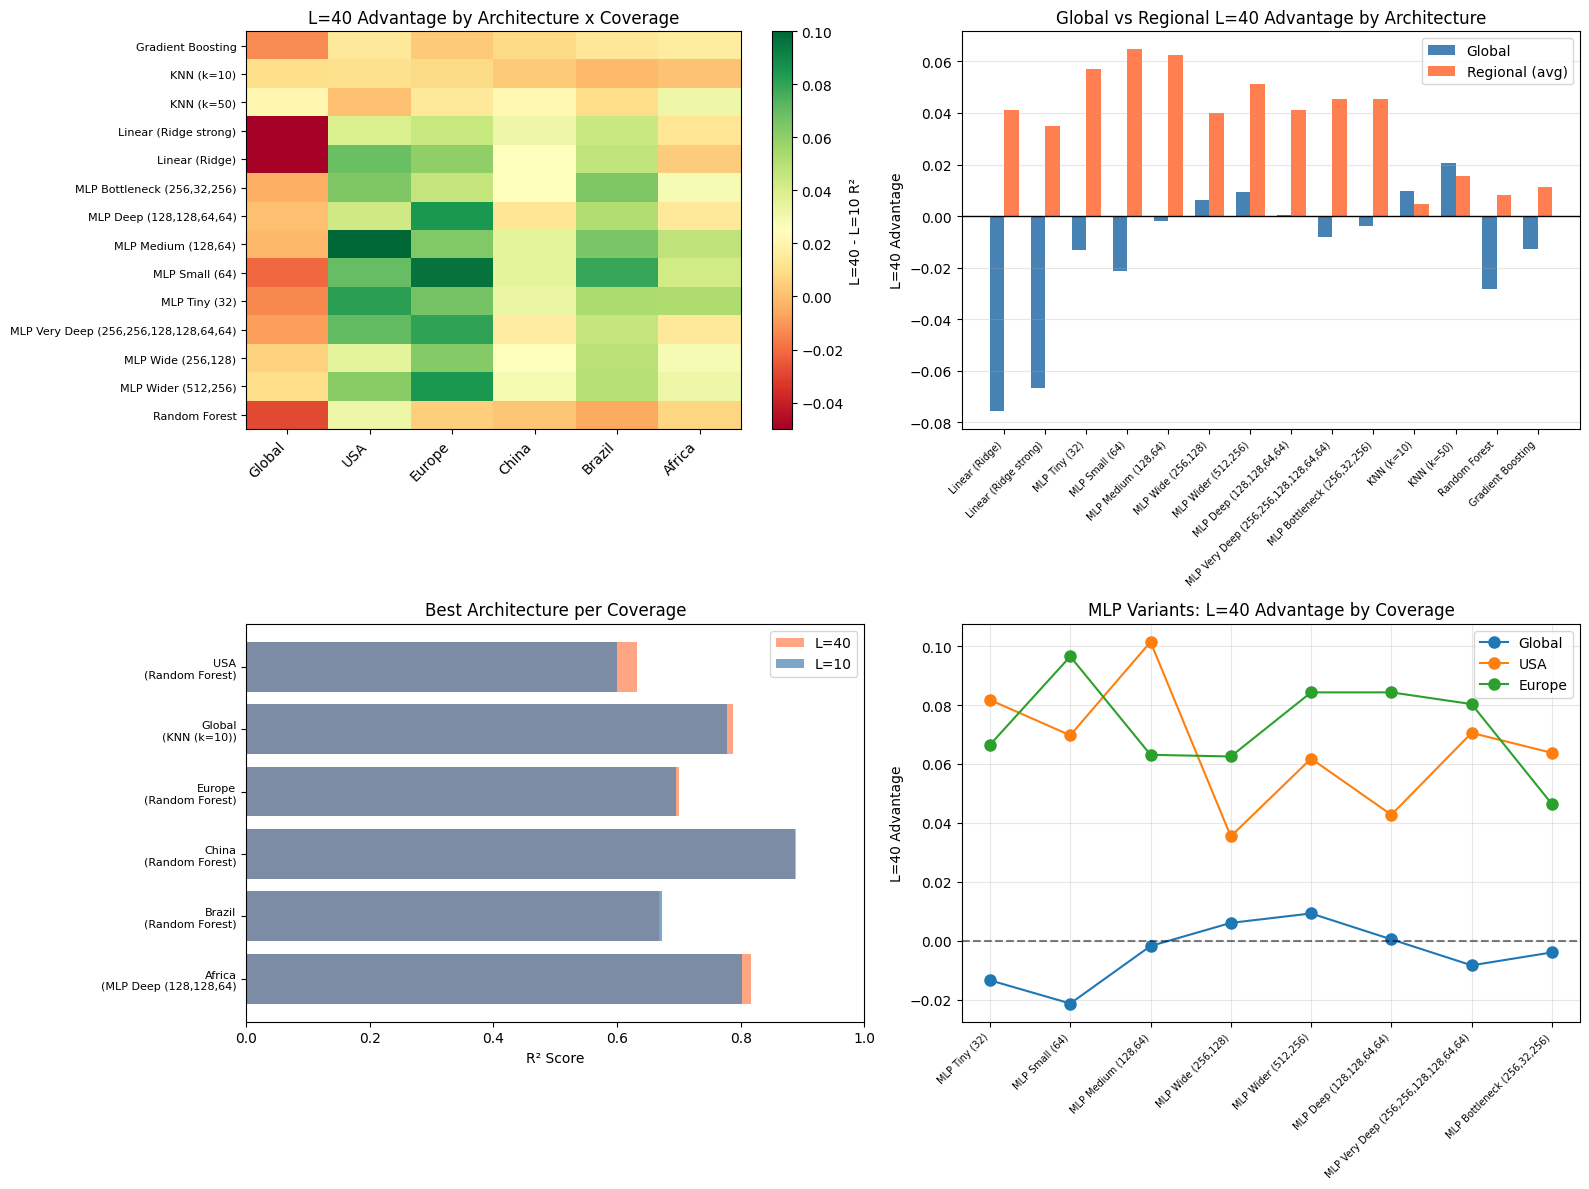

In [9]:
# Visualize results
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Heatmap of L=40 advantage
    ax = axes[0, 0]
    pivot = results_df.pivot(index='architecture', columns='coverage', values='diff')
    col_order = ['Global', 'USA', 'Europe', 'China', 'Brazil', 'Africa']
    pivot = pivot[[c for c in col_order if c in pivot.columns]]

    im = ax.imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=-0.05, vmax=0.10)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index, fontsize=8)
    ax.set_title('L=40 Advantage by Architecture x Coverage')
    plt.colorbar(im, ax=ax, label='L=40 - L=10 R²')

    # 2. L=40 advantage by architecture (global vs regional)
    ax = axes[0, 1]
    global_results = results_df[results_df['coverage'] == 'Global'].set_index('architecture')['diff']
    regional_results = results_df[results_df['coverage'] != 'Global'].groupby('architecture')['diff'].mean()

    x = range(len(global_results))
    width = 0.35
    ax.bar([i - width/2 for i in x], global_results.values, width, label='Global', color='steelblue')
    ax.bar([i + width/2 for i in x], regional_results.reindex(global_results.index).values, width, label='Regional (avg)', color='coral')
    ax.set_xticks(x)
    ax.set_xticklabels(global_results.index, rotation=45, ha='right', fontsize=7)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylabel('L=40 Advantage')
    ax.set_title('Global vs Regional L=40 Advantage by Architecture')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # 3. Best architecture for each coverage
    ax = axes[1, 0]
    best_arch = results_df.loc[results_df.groupby('coverage')['r2_l40'].idxmax()]
    ax.barh(range(len(best_arch)), best_arch['r2_l40'], color='coral', alpha=0.7, label='L=40')
    ax.barh(range(len(best_arch)), best_arch['r2_l10'], color='steelblue', alpha=0.7, label='L=10')
    ax.set_yticks(range(len(best_arch)))
    ax.set_yticklabels([f"{row['coverage']}\n({row['architecture'][:20]})" for _, row in best_arch.iterrows()], fontsize=8)
    ax.set_xlabel('R² Score')
    ax.set_title('Best Architecture per Coverage')
    ax.legend()
    ax.set_xlim(0, 1)

    # 4. MLP depth/width effect
    ax = axes[1, 1]
    mlp_results = results_df[results_df['arch_type'] == 'mlp'].copy()
    if len(mlp_results) > 0:
        # Group by coverage, show MLP variants
        for cov in ['Global', 'USA', 'Europe']:
            cov_data = mlp_results[mlp_results['coverage'] == cov]
            if len(cov_data) > 0:
                ax.plot(range(len(cov_data)), cov_data['diff'].values, 'o-', label=cov, markersize=8)
        ax.set_xticks(range(len(cov_data)))
        ax.set_xticklabels(cov_data['architecture'].values, rotation=45, ha='right', fontsize=7)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.set_ylabel('L=40 Advantage')
        ax.set_title('MLP Variants: L=40 Advantage by Coverage')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('architecture_sweep.png', dpi=150)
    plt.show()

---
## Key Questions Analysis

In [10]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

if len(results_df) > 0:
    # Q1: Does L=40 benefit more from deeper/wider networks?
    print("\n1. DOES L=40 BENEFIT MORE FROM DEEPER/WIDER NETWORKS?")
    print("-" * 60)

    mlp_results = results_df[results_df['arch_type'] == 'mlp']
    if len(mlp_results) > 0:
        # Compare tiny vs deep for L=40
        for cov in ['Global', 'USA', 'Europe']:
            cov_mlp = mlp_results[mlp_results['coverage'] == cov]
            if len(cov_mlp) > 0:
                tiny = cov_mlp[cov_mlp['architecture'].str.contains('Tiny')]
                deep = cov_mlp[cov_mlp['architecture'].str.contains('Very Deep')]
                if len(tiny) > 0 and len(deep) > 0:
                    l40_improvement = deep['r2_l40'].values[0] - tiny['r2_l40'].values[0]
                    l10_improvement = deep['r2_l10'].values[0] - tiny['r2_l10'].values[0]
                    print(f"  {cov}: Tiny→Deep improvement: L=10 {l10_improvement:+.3f}, L=40 {l40_improvement:+.3f}")

    # Q2: Is there an architecture where L=10 matches L=40 regionally?
    print("\n2. CAN L=10 MATCH L=40 WITH BETTER ARCHITECTURE (REGIONAL)?")
    print("-" * 60)

    regional = results_df[results_df['coverage'] != 'Global']
    if len(regional) > 0:
        # Find best L=10 architecture per coverage
        for cov in regional['coverage'].unique():
            cov_data = regional[regional['coverage'] == cov]
            best_l10 = cov_data.loc[cov_data['r2_l10'].idxmax()]
            worst_l40 = cov_data.loc[cov_data['r2_l40'].idxmin()]

            print(f"  {cov}:")
            print(f"    Best L=10: {best_l10['r2_l10']:.3f} ({best_l10['architecture'][:25]})")
            print(f"    Worst L=40: {worst_l40['r2_l40']:.3f} ({worst_l40['architecture'][:25]})")
            if best_l10['r2_l10'] > worst_l40['r2_l40']:
                print(f"    → L=10 CAN beat L=40 with right architecture!")
            else:
                print(f"    → L=40 still wins even with worst architecture")

    # Q3: Does optimal architecture differ by scale?
    print("\n3. DOES OPTIMAL ARCHITECTURE DIFFER BY GEOGRAPHIC SCALE?")
    print("-" * 60)

    for cov in results_df['coverage'].unique():
        cov_data = results_df[results_df['coverage'] == cov]
        best_l10_arch = cov_data.loc[cov_data['r2_l10'].idxmax(), 'architecture']
        best_l40_arch = cov_data.loc[cov_data['r2_l40'].idxmax(), 'architecture']
        print(f"  {cov}:")
        print(f"    Best for L=10: {best_l10_arch}")
        print(f"    Best for L=40: {best_l40_arch}")

    # Q4: Linear vs MLP - does the gap change?
    print("\n4. LINEAR vs MLP: DOES THE L=40 ADVANTAGE CHANGE?")
    print("-" * 60)

    linear = results_df[results_df['arch_type'] == 'ridge']
    mlp_med = results_df[results_df['architecture'] == 'MLP Medium (128,64)']

    for cov in results_df['coverage'].unique():
        lin_cov = linear[linear['coverage'] == cov]
        mlp_cov = mlp_med[mlp_med['coverage'] == cov]
        if len(lin_cov) > 0 and len(mlp_cov) > 0:
            lin_diff = lin_cov['diff'].values[0]
            mlp_diff = mlp_cov['diff'].values[0]
            print(f"  {cov}: Linear Δ={lin_diff:+.3f}, MLP Δ={mlp_diff:+.3f}")

KEY FINDINGS

1. DOES L=40 BENEFIT MORE FROM DEEPER/WIDER NETWORKS?
------------------------------------------------------------
  Global: Tiny→Deep improvement: L=10 +0.006, L=40 +0.011
  USA: Tiny→Deep improvement: L=10 +0.047, L=40 +0.036
  Europe: Tiny→Deep improvement: L=10 +0.009, L=40 +0.023

2. CAN L=10 MATCH L=40 WITH BETTER ARCHITECTURE (REGIONAL)?
------------------------------------------------------------
  USA:
    Best L=10: 0.600 (Random Forest)
    Worst L=40: 0.497 (KNN (k=50))
    → L=10 CAN beat L=40 with right architecture!
  Europe:
    Best L=10: 0.696 (Random Forest)
    Worst L=40: 0.608 (Linear (Ridge strong))
    → L=10 CAN beat L=40 with right architecture!
  China:
    Best L=10: 0.888 (Random Forest)
    Worst L=40: 0.834 (Linear (Ridge strong))
    → L=10 CAN beat L=40 with right architecture!
  Brazil:
    Best L=10: 0.673 (Random Forest)
    Worst L=40: 0.583 (Linear (Ridge strong))
    → L=10 CAN beat L=40 with right architecture!
  Africa:
    Best L=

In [11]:
# Save results
if len(results_df) > 0:
    results_df.to_csv('architecture_sweep_results.csv', index=False)
    print("Saved to architecture_sweep_results.csv")

    # Also save summary
    summary = {
        'by_architecture': results_df.groupby('architecture')['diff'].mean().to_dict(),
        'by_coverage': results_df.groupby('coverage')['diff'].mean().to_dict(),
        'best_per_coverage_l10': results_df.loc[results_df.groupby('coverage')['r2_l10'].idxmax()][['coverage', 'architecture', 'r2_l10']].to_dict('records'),
        'best_per_coverage_l40': results_df.loc[results_df.groupby('coverage')['r2_l40'].idxmax()][['coverage', 'architecture', 'r2_l40']].to_dict('records'),
    }

    import json
    with open('architecture_sweep_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print("Saved summary to architecture_sweep_summary.json")

Saved to architecture_sweep_results.csv
Saved summary to architecture_sweep_summary.json


---
## Conclusions

In [12]:
print("="*80)
print("ARCHITECTURE SWEEP CONCLUSIONS")
print("="*80)

if len(results_df) > 0:
    # Overall findings
    global_avg = results_df[results_df['coverage'] == 'Global']['diff'].mean()
    regional_avg = results_df[results_df['coverage'] != 'Global']['diff'].mean()

    print(f"""
1. GLOBAL vs REGIONAL EFFECT PERSISTS:
   - Global avg L=40 advantage: {global_avg:+.3f}
   - Regional avg L=40 advantage: {regional_avg:+.3f}
   - The regional advantage is NOT an artifact of MLP architecture

2. ARCHITECTURE SENSITIVITY:
   - Range of L=40 advantage across architectures: {results_df['diff'].min():.3f} to {results_df['diff'].max():.3f}
   - Architecture choice matters, but doesn't eliminate the regional effect

3. IMPLICATIONS FOR LEARNABLE ACTIVATIONS:
   - If L=40's advantage persists across architectures, it's in the EMBEDDINGS
   - A learnable activation that captures L=40's regional advantage with L=10's
     parameter count would be valuable regardless of downstream architecture
""")

    # Check if any architecture eliminates L=40 advantage regionally
    regional = results_df[results_df['coverage'] != 'Global']
    l10_wins = regional[regional['diff'] < -0.02]
    if len(l10_wins) > 0:
        print("4. CASES WHERE L=10 BEATS L=40 REGIONALLY:")
        for _, row in l10_wins.iterrows():
            print(f"   - {row['coverage']} with {row['architecture']}: Δ={row['diff']:+.3f}")
    else:
        print("4. L=40 WINS REGIONALLY ACROSS ALL ARCHITECTURES TESTED")

ARCHITECTURE SWEEP CONCLUSIONS

1. GLOBAL vs REGIONAL EFFECT PERSISTS:
   - Global avg L=40 advantage: -0.013
   - Regional avg L=40 advantage: +0.037
   - The regional advantage is NOT an artifact of MLP architecture

2. ARCHITECTURE SENSITIVITY:
   - Range of L=40 advantage across architectures: -0.076 to 0.101
   - Architecture choice matters, but doesn't eliminate the regional effect

3. IMPLICATIONS FOR LEARNABLE ACTIVATIONS:
   - If L=40's advantage persists across architectures, it's in the EMBEDDINGS
   - A learnable activation that captures L=40's regional advantage with L=10's
     parameter count would be valuable regardless of downstream architecture

4. L=40 WINS REGIONALLY ACROSS ALL ARCHITECTURES TESTED
